# List 11
## Hidden Markov models (HMM) - Inference

### Knowledge & Skills:

 - HMM
 - Viterbi algorithm
 
### Remarks
 - Do not repeat yourself, check if the implementation of one task is also the implementation of others,
 - Do not copy your code, create functions and reuse them
 - Use env that will help you solve problems not create new ones in given task
 - [YouTube](https://www.youtube.com/watch?v=RwwfUICZLsA)
 - [YouTube 2](https://www.youtube.com/watch?v=0dVUfYF8ko0)


In [1]:
!pip install numpy pandas networkx

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def viterbi(obs, model):
    states = model.states
    start_p = model.Pstart
    trans_p = model.Ptransition
    emit_p = model.Pemission
    V = [{}]
    for st in states['states'].values:
        V[0][st] = {
            "prob": start_p.loc[st, 'probability'] * emit_p.loc[st, obs[0]],
            "prev": None,
        }
    for t in range(1, len(obs)):
        V.append({})
        for st in states['states'].values:
            max_tr_prob = max(
                V[t-1][prev_st]["prob"] * trans_p.loc[prev_st, st]
                for prev_st in states['states'].values
            )
            for prev_st in states['states'].values:
                if V[t-1][prev_st]["prob"] * trans_p.loc[prev_st, st] == max_tr_prob:
                    max_prob = max_tr_prob * emit_p.loc[st, obs[t]]
                    V[t][st] = {"prob": max_prob, "prev": prev_st}
                    break
    display(pd.DataFrame(V).applymap(lambda x: x['prob']).T)
    
    opt = []
    max_prob = max(value["prob"] for value in V[-1].values())
    previous = None
    for st, data in V[-1].items():
        if data["prob"] == max_prob:
            opt.append(st)
            previous = st
            break
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]
    display(pd.DataFrame(opt, columns=['State sequence']).T)
    print('Max probability: {}'.format(max_prob))

Exercise 1
============

**Prepare representation of HMM: (apropriate classes representing states, observations, emission probabilities, transition probabilities).**

In [4]:
class HMM:
    observations = pd.DataFrame()
    states = pd.DataFrame()
    Pstart = pd.DataFrame()
    Ptransition = pd.DataFrame()
    Pemission = pd.DataFrame()
    
    def display(self):
        display(self.observations)
        display(self.states)
        display(self.Pstart)
        display(self.Ptransition)
        display(self.Pemission)

In [5]:
hmm = HMM()
hmm.observations = pd.DataFrame(['sleeping', 'eating', 'pooping'], columns=['observations'])
hmm.states = pd.DataFrame(['Healthy', 'Sick'], columns=['states'])

hmm.Pstart = pd.DataFrame([
    pd.Series({ 'probability': 0.75 }, name='Healthy'),
    pd.Series({ 'probability': 0.25 }, name='Sick'),
], columns=['probability'])

hmm.Ptransition = pd.DataFrame([
    pd.Series({'Healthy': 0.8, 'Sick': 0.2}, name='Healthy'),
    pd.Series({'Healthy': 0.4, 'Sick': 0.6}, name='Sick')
], columns = hmm.states['states'].tolist())

hmm.Pemission = pd.DataFrame([
    pd.Series({'sleeping': 0.5, 'eating': 0.4, 'pooping': 0.1}, name='Healthy'),
    pd.Series({'sleeping': 0.1, 'eating': 0.3, 'pooping': 0.6}, name='Sick')
], columns = hmm.observations['observations'].tolist())
hmm.display()

,observations
0,sleeping
1,eating
2,pooping


,states
0,Healthy
1,Sick


,probability
Healthy,0.75
Sick,0.25


,Healthy,Sick
Healthy,0.8,0.2
Sick,0.4,0.6


,sleeping,eating,pooping
Healthy,0.5,0.4,0.1
Sick,0.1,0.3,0.6


Exercise 2
============

**Create one simple HMM model.**

In [6]:
def getMarkovEdges(*Qs):
    edges = []
    for Q in Qs:
        for col in Q.columns:
            for idx in Q.index:
                edges += [(idx, col, Q.loc[idx,col])]
    return edges

In [7]:
G = nx.MultiDiGraph()

G.add_nodes_from(['Start'], Type='Start')
G.add_nodes_from(hmm.states['states'], Type='States')
G.add_nodes_from(hmm.observations['observations'], Type='Observations')



for u, v, w in getMarkovEdges(hmm.Pemission):
    G.add_edge(u, v, weight=w, label=w, Type='Emission')

edges = [('Start', idx, hmm.Pstart.loc[idx, 'probability']) for idx in hmm.Pstart.index]
for u, v, w in (edges + getMarkovEdges(hmm.Ptransition)):
    G.add_edge(u, v, weight=w, label=w, Type='Normal')

EdgeEmission = [n for (n, ty) in nx.get_edge_attributes(G,'Type').items() if ty == 'Emission']    
EdgeNormal = [n for (n, ty) in nx.get_edge_attributes(G,'Type').items() if ty == 'Normal']

Exercise 3
============

**Visualize created model (picture of graph, differend vertices shapes for hidden states, different for observations etc.).**

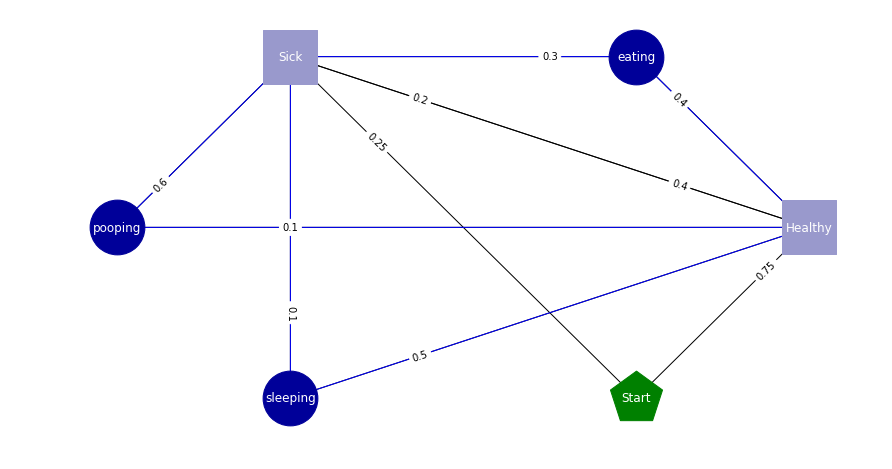

In [8]:
plt.figure(figsize=(15, 8))
plt.axis('off')

NodeStart = [n for (n,ty) in nx.get_node_attributes(G,'Type').items() if ty == 'Start']
NodeStates = [n for (n,ty) in nx.get_node_attributes(G,'Type').items() if ty == 'States']
NodeObservations = [n for (n,ty) in nx.get_node_attributes(G,'Type').items() if ty == 'Observations']

pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, font_color='w')
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='g', node_shape='p', nodelist=NodeStart)
nx.draw_networkx_nodes(G, pos, node_size=3000, node_shape='s', node_color='#9999cc', nodelist=NodeStates)
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='#000099', nodelist=NodeObservations)

nx.draw_networkx_edges(G, pos, edgelist=EdgeEmission, edge_color='b', width=1)

emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, label_pos=0.25, edge_labels=emit_edge_labels, arrowstyle='->', arrowsize=12)
None

Exercise 4
============

**Implement method that will compute most probable state sequence for given observed sequence (Viterbi algorithm).**

In [9]:
seq = ('eating', 'eating', 'sleeping', 'sleeping', 'pooping', 'pooping', 'eating')
viterbi(seq, hmm)

,0,1,2,3,4,5,6
Healthy,0.300,0.096,0.03840,0.015360,0.001229,0.000098,0.000106
Sick,0.075,0.018,0.00192,0.000768,0.001843,0.000664,0.000119


,0,1,2,3,4,5,6
State sequence,Healthy,Healthy,Healthy,Healthy,Sick,Sick,Sick


Max probability: 0.00011943936000000004
